In [1]:
import pandas as pd
import pingouin as pg

In [2]:
# importing custom functions from this repository
from helper_functions import *

### These analyses are based on the code provided by Cooper and Ritchey (2022), which can be found here: https://github.com/memobc/paper-vividness-features

### They have been extended to allow for an additional manipulation of an age group (both young and older adults have been tested) and an additional dependent variable - a confidence rating

### Analyses

Each participant’s performance was evaluated in eight ways: vividness rating (continuous between 1 and 6), confidence rating (continuous between 1 and 6), and gist as well as detail memory for place, object and person (1 - correct or 0 - incorrect).  

First, we removed participants whose performance on the experiment met our preregistered exclusion criteria (7 participants removed).

Next, we assessed the effect of age on memory performance. We compared memory performance on gist and memory performance on detail between the two age groups using Man-Whitney U-test. 

The main analyses of interest focused on the trial-wise relationship between subjective ratings of confidence and vividness and memory attributes. This was done in two ways: using within-participant correlations between subjective memory ratings and each of the memory attributes, and predictive linear models exploring which memory attributes predict subjective memory rating. When running group analyses, participant correlations were Fisher-z transformed across the two ageing groups. One sample and two sample Bonferroni corrected t-tests were run to test whether the correlations were different from 0 and whether there were between-group differences associated with ageing. To assess the relationship between subjective memory ratings within and across age groups, we conducted Spearman correlations and Man-Whitney U-tests to check for differences in vividness and confidence ratings.  

We also assessed whether the relationship between subjective memory experience, as measured by confidence and vividness ratings, is associated with overall memory performance. Each event consisted of 6 memory attribute evaluations. The correlation was calculated between the total number of memory attributes remembered (0-6) and the two subjective memory ratings, separately. Following this, gist and detail memory attributes correlations were calculated separately for each type of memory content with both subjective measures, separately. As in the original study, we marked the detail memory trials as incorrect if participants did not respond correctly to the corresponding gist question. This is because if a participant did not remember the gist of the event correctly, the detailed information tested on correct original event elements could not have contributed to the subjectively experienced vividness. To assess the differential effect of specificity (gist versus detail) and content (person, object or place) on the subjective memory ratings across the two age groups, we conducted an ageing (between subjects, 2 levels: older adults, young adults) x specificity (within subjects, 2 levels: gist, detail) x content (within subjects, 3 levels: object, person, place) mixed-effects ANOVAs, separately for confidence and vividness. The dependent variable was the Fisher transformed correlation coefficient between subjective memory rating and memory performance on each of the memory attributes.  

Additionally, we used predictive linear regression model tested with repeated cross validation to test whether trial-wise memory attributes can predict subjective ratings of left-out events within each group, and which combination of memory attributes explains the most variance in subjective memory ratings within each group. This was performed separately for young and older adults, and separately for ratings of vividness and confidence. Full models included all six memory attributes. On each iteration, the predictor explaining the lowest amount of variance in the model was removed. The best model was defined as the model with the highest out-of-sample R-squared value.  

Given the reported substantial individual variability in the findings of Cooper and Ritchey (2022), we also explored individual differences in the relationship between the subjective ratings of confidence and vividness and memory attributes. First, we conducted correlations between mean subjective memory ratings (separately for confidence and vividness) and each of the memory attributes, as well as scores on the two questionnaires - the episodic Survey of Autobiographical Memory and the Vividness of Visual Imagery Questionnaire. Second, we performed K-Means clustering to group participants based on the similarity, defined as Euclidean distance, of the correlations between all memory attributes and subjective memory measures. We identified the elbow of the curve of inertia values, defined as the sum of squared distances of each participant to their closest cluster centre, calculated using between one and ten clusters. For each k iteration, K-Means was run 500 times, returning the cluster assignments with the lowest inertia. K-Means clustering was run separately for confidence and vividness, separately for older and young adults.  

# List of content
## 1. Data checks
#### *1.1 Checking exclusion criteria*
#### *1.2 Encoding time checks*
#### *1.3 Memory Vividness and Confidence checks*
#### *1.4 Gist and Detail Memory performance checks*

## 2. Subjective and objective memory score correlations
#### *2.1 Correlation between total gist and total detail performance (collapsed across content conditions of place/person/object) and subjective ratings*
#### *2.2 Setting detail performance to be conditional upon gist performance*
#### *2.3 Correlation between total number of attributes remembered (collapsed across specificity conditions of gist/detail and content conditions of place/person/object) and subjective ratings*
#### *2.4 Correlation between the correlation coefficients of vividness and total number of remembered attributes, and confidence and total number of remembered attributes*

## 3. Content x Specificity x Age
#### *3.1 The effect of content x specificity x age on vividness ratings*
#### *3.2 The effect of content x specificity x age on confidence ratings*

## 4. Mixed-design 3x2x2 ANOVA

## 5. Predictive model
#### 5.1 Vividness
#### 5.2 Confidence


# 1. Data checks

## 1.1 Checking exclusion criteria

In [3]:
df = pd.read_csv('.\data\data.csv')
df.head()

,participant,event_id,encoding.thisN,theme,object_label,person_label,place_label,resp_encSpace.rt,retrieval.thisN,resp_ret_vividness.keys,...,sun_4,shop_1,shop_2,shop_3,shop_4,scene_1,scene_2,scene_3,scene_4,age
0,100,17,1,Summer,Puppy,Sandra,Circus,15.0042,9,1.703704,...,5,5,3,4,2,5,4,5,4,0
1,100,11,2,Games,Binoculars,Harrison,Lake,12.2719,6,5.805556,...,5,5,3,4,2,5,4,5,4,0
2,100,18,3,DIY,Chair,Beyonce,Winecellar,18.8351,15,5.888889,...,5,5,3,4,2,5,4,5,4,0
3,100,4,4,Exercise,Beachball,Will,Casino,10.3913,23,2.462963,...,5,5,3,4,2,5,4,5,4,0
4,100,10,5,Work,Easel,Sean,Aquarium,16.0599,18,5.370371,...,5,5,3,4,2,5,4,5,4,0


The experiment consisted of 24 trials. We're checking if all participants completed the experiment:

In [4]:
ntrials = df.groupby('participant').count()
if any(ntrials["event_id"] != 24):
    print('Check data. Some participant have an incorrect number of trials')
else:
    print('All participants have 24 trials')

All participants have 24 trials


We will exclude participants
                     - whose median reaction time is less than 0.75s
                     - who press the same key more than 75% of the time
                     - whose gist memory performance was close to or below chance, using the threshold of 30% (chance = 25%).

In [5]:
# check data and return cleaned data and a list of subject IDs to exclude:
df, exclude_subs = quality_check(df)


Number of subjects with median RT <= .75s -- 0 out of 200 subjects

Number of subjects with consistent key presses (> 75% same key) -- 0 out of 200 subjects

Number of subjects with gist memory <= 30% -- 7 out of 200 subjects

Removing subjects from data .... 114,115,119,124,134,152,171


In [6]:
# we are not using detail memory as an exclusion check to avoid penalising people who rely more heavily on gist
detail = df[['participant','age',
                  'resp_detailmem1.corr','resp_detailmem2.corr','resp_detailmem3.corr']].melt(id_vars=['participant', 'age'])
detail = detail.groupby(['participant']).mean().reset_index()

# exclude? chance is 50%
ps = detail.loc[detail['value'] <=.55,['participant', 'age']]
print('\nNumber of older participants with detail memory <= 55% --',len(ps.loc[ps['age'] == 1.0]))
print('\nNumber of younger participants with detail memory <= 55% --',len(ps.loc[ps['age'] == 0.0]))
print('\nParticipants ids: ', ps['participant'].tolist())


Number of older participants with detail memory <= 55% -- 13

Number of younger participants with detail memory <= 55% -- 8

Participants ids:  [10, 14, 15, 18, 24, 25, 32, 35, 41, 43, 82, 84, 89, 101, 113, 130, 148, 154, 166, 175, 193]


In [7]:
# number of remaining participants
print('** FINAL ANALYSIS N =', len(df['participant'].unique()), '**')
print('\n** Older adults N =', len(df.loc[df['age'] == 1, 'participant'].unique()), '**')
print('\n** Young adults N =', len(df.loc[df['age'] == 0, 'participant'].unique()), '**\n')

** FINAL ANALYSIS N = 193 **

** Older adults N = 97 **

** Young adults N = 96 **



In [8]:
# save df for individual differences analysis
df.to_csv('.\data\data_cleaned.csv')

### Ex

## 1.2 Encoding time checks

In [9]:
encoding_differences = df.copy()
encoding_differences['is_encoding_na'] = encoding_differences['resp_encSpace.rt'].isna()
encoding_differences = encoding_differences['resp_encSpace.rt'].isnull().groupby([encoding_differences['participant'],encoding_differences['age']]).sum().astype(int).reset_index(name='count')

In [10]:
encoding_differences.groupby('age').agg(Mean=('count', 'mean'), SD=('count', np.std))

,Mean,SD
age,,
0,6.937500,8.336114
1,17.216495,7.559799


In [11]:
pg.mwu(encoding_differences.loc[encoding_differences['age'] == 1, 'count'], encoding_differences.loc[encoding_differences['age'] == 0, 'count'], alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,7603.5,two-sided,2.357864e-14,-0.633054,0.816527


In [12]:
# If resp_encSpace.rt == NaN, it means that participant never pressed the space bar. In this case, we count as the maximum possible time
#df['resp_encSpace.rt'] = df['resp_encSpace.rt'].fillna(20)

In [13]:
data_age = pd.DataFrame(df.groupby(['participant', 'age']).mean(numeric_only=True)['resp_encSpace.rt'])
data_age.columns = ['mean story generation time']

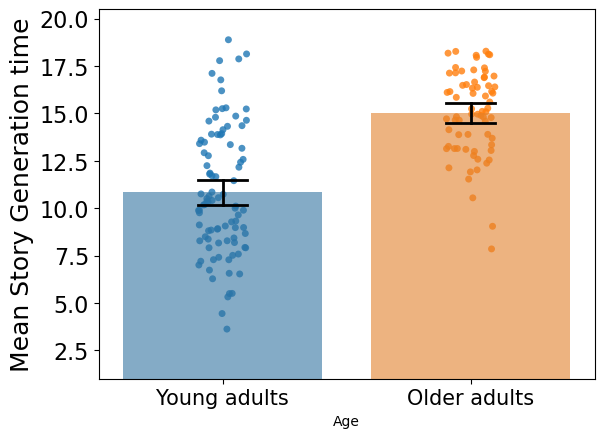

In [14]:
sns.barplot(y='mean story generation time', x='age',
            data=data_age.reset_index(),
            alpha=.6, dodge=True, errcolor="k",
            errwidth=2, capsize=.2)
sns.stripplot(y='mean story generation time', x='age',
              data=data_age.reset_index(),
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Story Generation time', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)
plt.ylim(1,20.5)

plt.show()

In [15]:
enc_rt = pd.DataFrame(df.groupby(['participant','age']).mean(numeric_only=True)['resp_encSpace.rt'])
enc_rt.groupby(['age']).agg(Mean=('resp_encSpace.rt', 'mean'),
           SD=('resp_encSpace.rt', np.std))

,Mean,SD
age,,
0,10.845169,3.365571
1,15.001867,2.228181


## 1.3 Memory Vividness and Confidence checks

In [16]:
data_age = pd.DataFrame(df.groupby(['participant','age'], as_index=False)[['resp_ret_confidence.keys','resp_ret_vividness.keys']].mean())
older_part_df, younger_part_df = [x for _, x in df.groupby(df['age'] == 0)]

In [17]:
len(data_age['participant'].unique())

193

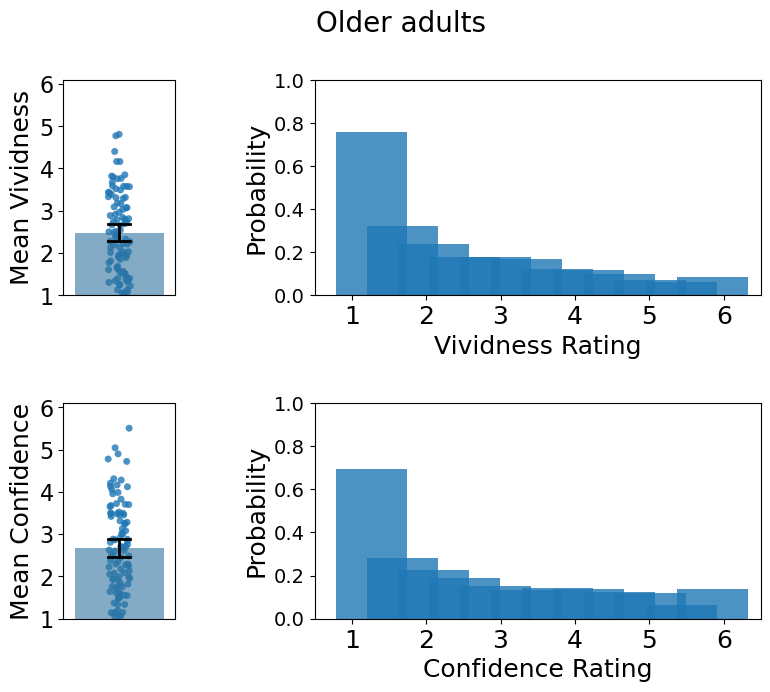

In [18]:
# plotting older adults descriptive data:
fig, axes = plt.subplots(2, 2, figsize=(9,7),
                         gridspec_kw={
                               'width_ratios': [1, 4],
                               'wspace': 0.5,
                                'hspace': 0.5})
fig.suptitle('Older adults', fontsize=20)

# vividness older adults
plt.axes(axes[0,0])
sns.barplot(y="resp_ret_vividness.keys",data=data_age.loc[data_age.age == 1], alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y="resp_ret_vividness.keys",data=data_age.loc[data_age.age == 1],
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Vividness', fontsize=18)
plt.yticks(fontsize=16)
plt.grid(False)
plt.xticks([])
plt.ylim(1,6.1)


# confidence older adults
plt.axes(axes[1,0])
sns.barplot(y="resp_ret_confidence.keys",data=data_age.loc[data_age.age == 1], alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y="resp_ret_confidence.keys",data=data_age.loc[data_age.age == 1],
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Confidence', fontsize=18)
plt.yticks(fontsize=16)
plt.grid(False)
plt.xticks([])
plt.ylim(1,6.1)


# show distribution of values for vividness:
plt.axes(axes[0,1])
older_part_df.hist(ax=axes[0,1], column='resp_ret_vividness.keys', bins=12,
            xlabelsize=16, ylabelsize=14, width=0.95, alpha=.8,
            range=(1,6), align='left', density=True)
plt.xlabel('Vividness Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)


# show distribution of values for confidence:
plt.axes(axes[1,1])
older_part_df.hist(ax=axes[1,1], column='resp_ret_confidence.keys', bins=12,
            xlabelsize=16, ylabelsize=14, width=0.95, alpha=.8,
            range=(1,6), align='left', density=True)
plt.xlabel('Confidence Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)


plt.show()

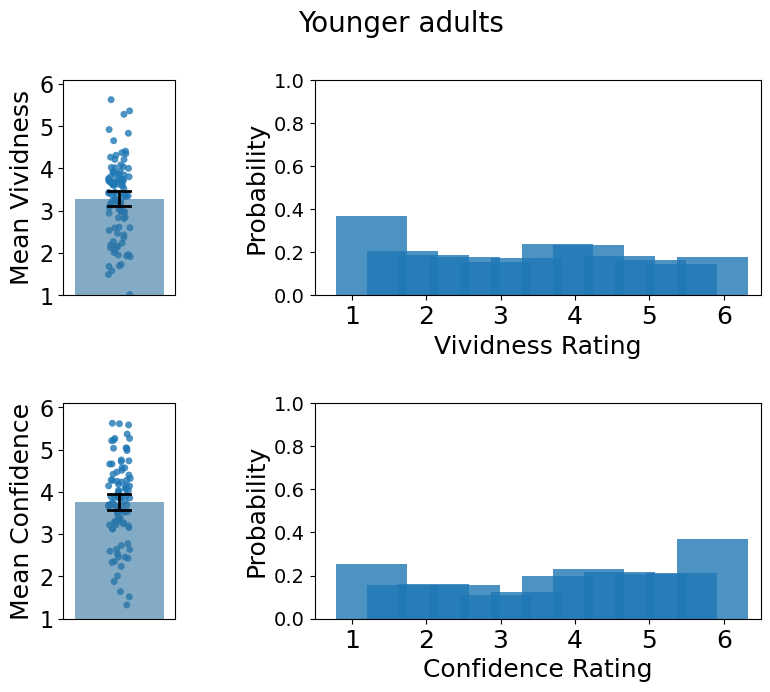

In [19]:
# plotting younger adults descriptive data:
fig, axes = plt.subplots(2, 2, figsize=(9,7),
                         gridspec_kw={
                               'width_ratios': [1, 4],
                               'wspace': 0.5,
                               'hspace': 0.5})

fig.suptitle('Younger adults', fontsize=20)

# vividness younger adults
plt.axes(axes[0,0])
sns.barplot(y='resp_ret_vividness.keys',data=data_age.loc[data_age.age == 0], alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='resp_ret_vividness.keys',data=data_age.loc[data_age.age == 0],
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Vividness', fontsize=18)
plt.yticks(fontsize=16)
plt.grid(False)
plt.xticks([])
plt.ylim(1,6.1)


# confidence younger adults
plt.axes(axes[1,0])
sns.barplot(y='resp_ret_confidence.keys',data=data_age.loc[data_age.age == 0], alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='resp_ret_confidence.keys',data=data_age.loc[data_age.age == 0],
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Confidence', fontsize=18)
plt.yticks(fontsize=16)
plt.grid(False)
plt.xticks([])
plt.ylim(1,6.1)


# show distribution of vividness values:
plt.axes(axes[0,1])
younger_part_df.hist(ax=axes[0,1], column='resp_ret_vividness.keys', bins=12,
            xlabelsize=16, ylabelsize=14, width=0.95, alpha=.8,
            range=(1,6), align='left', density=True)
plt.xlabel('Vividness Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)

# show distribution of confidence values:
plt.axes(axes[1,1])
younger_part_df.hist(ax=axes[1,1], column='resp_ret_confidence.keys', bins=12,
            xlabelsize=16, ylabelsize=14, width=0.95, alpha=.8,
            range=(1,6), align='left', density=True)
plt.xlabel('Confidence Rating', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.title('')
plt.grid(False)


plt.show()

Is there a difference between young vs older adults in confidence and vividness ratings?

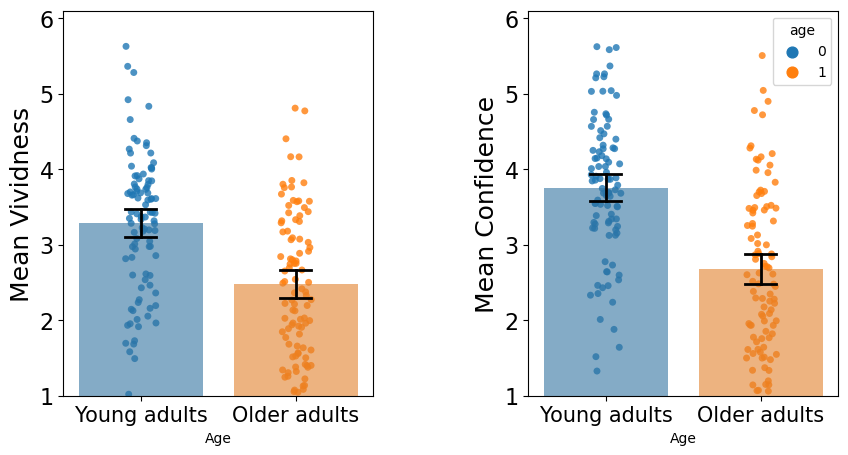

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,5),
                         gridspec_kw={
                               'width_ratios': [1, 1],
                               'wspace': 0.5,
                               'hspace': 0.5})

# vividness
plt.axes(axes[0])
sns.barplot(y='resp_ret_vividness.keys',x='age',data=data_age, alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='resp_ret_vividness.keys',x='age',data=data_age,
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylim(1,6.1)
plt.ylabel('Mean Vividness', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)

# confidence
plt.axes(axes[1])
sns.barplot(y='resp_ret_confidence.keys',x='age',data=data_age, alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='resp_ret_confidence.keys',x='age',data=data_age,
              hue='age',
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylim(1,6.1)
plt.ylabel('Mean Confidence', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)

plt.show()

In [21]:
pg.normality(df, dv='resp_ret_vividness.rt', group='age', method='shapiro', alpha=0.05)

,W,pval,normal
age,,,
0,0.559086,0.0,False
1,0.768606,0.0,False


In [22]:
pg.mwu(older_part_df['resp_ret_vividness.keys'], younger_part_df['resp_ret_vividness.keys'], alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,1841089.5,two-sided,3.237158e-76,0.313502,0.343249


In [23]:
data_age.groupby('age').agg(Mean=('resp_ret_vividness.keys', 'mean'),
                                     SE=('resp_ret_vividness.keys', 'sem'), SD=('resp_ret_vividness.keys', np.std))

,Mean,SE,SD
age,,,
0,3.282665,0.092546,0.906765
1,2.475960,0.095128,0.936901


In [24]:
pg.normality(df, dv='resp_ret_confidence.rt', group='age', method='shapiro', alpha=0.05)

,W,pval,normal
age,,,
0,0.382305,0.0,False
1,0.784308,0.0,False


In [25]:
pg.mwu(older_part_df['resp_ret_confidence.keys'], younger_part_df['resp_ret_confidence.keys'], alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,1656854.5,two-sided,2.399374e-112,0.382199,0.308901


In [26]:
data_age.groupby('age').agg(Mean=('resp_ret_confidence.keys', 'mean'),
                                     SE=('resp_ret_confidence.keys', 'sem'),
                            SD=('resp_ret_confidence.keys', np.std))

,Mean,SE,SD
age,,,
0,3.754311,0.095723,0.937892
1,2.679033,0.106683,1.050706


## 1.4 Gist and Detail Memory performance checks

In [27]:
memory_data = format_memory_data(df)

C:\Users\km675\PycharmProjects\ageing_vividness_confidence\helper_functions.py:101: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  memory_data = memory_data.merge(feature_wide, on=['participant', 'event'])
C:\Users\km675\PycharmProjects\ageing_vividness_confidence\helper_functions.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  memory_data = memory_data.merge(feature_wide, on=['participant', 'event'])


In [28]:
specificity_data = memory_data
specificity_data['total_gist'] = specificity_data['gist_object'] + specificity_data['gist_person'] + specificity_data['gist_place']
specificity_data['total_detail'] = specificity_data['detail_object'] + specificity_data['detail_person'] + specificity_data['detail_place']

In [29]:
older_specificity_data, younger_specificity_data = [x for _, x in specificity_data.groupby(specificity_data['age'] == 0)]

In [30]:
older_specificity_data = (older_specificity_data.groupby('participant'))[['total_gist', 'total_detail', 'age']].mean()

In [31]:
younger_specificity_data = (younger_specificity_data.groupby('participant'))[['total_gist', 'total_detail', 'age']].mean()

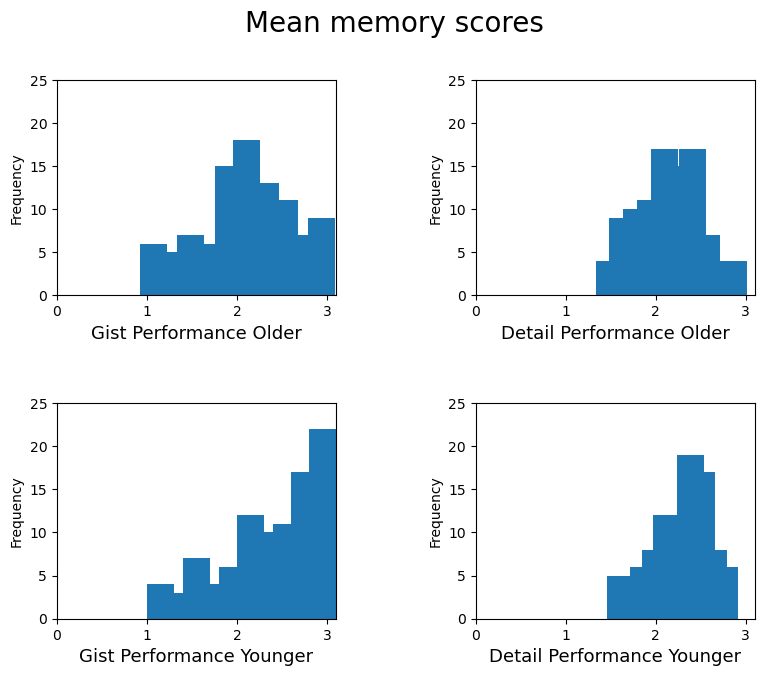

In [32]:
# plotting younger adults descriptive data:
fig, axes = plt.subplots(2,2, figsize=(9,7),
                         gridspec_kw={
                               'width_ratios': [1, 1],
                               'wspace': 0.5,
                               'hspace': 0.5})

fig.suptitle('Mean memory scores', fontsize=20)


# show distribution of gist older values:
plt.axes(axes[0,0])
older_specificity_data.hist(ax=axes[0,0], column='total_gist', width=0.3)
plt.xlabel('Gist Performance Older', fontsize=13)
plt.ylabel('Frequency', fontsize=10)
plt.xlim([0,3.1])
plt.ylim([0,25])
plt.title('')
plt.grid(False)

# show distribution of gist younger values:
plt.axes(axes[1,0])
younger_specificity_data.hist(ax=axes[1,0], column='total_gist', width=0.3)
plt.xlabel('Gist Performance Younger', fontsize=13)
plt.ylabel('Frequency', fontsize=10)
plt.xlim([0,3.1])
plt.ylim([0,25])
plt.title('')
plt.grid(False)

# show distribution of detail older values:
plt.axes(axes[0,1])
older_specificity_data.hist(ax=axes[0,1], column='total_detail', width=0.3)
plt.xlabel('Detail Performance Older', fontsize=13)
plt.ylabel('Frequency', fontsize=10)
plt.xlim([0,3.1])
plt.ylim([0,25])
plt.title('')
plt.grid(False)

# show distribution of detail younger values:
plt.axes(axes[1,1])
younger_specificity_data.hist(ax=axes[1,1], column='total_detail', width=0.3)
plt.xlabel('Detail Performance Younger', fontsize=13)
plt.ylabel('Frequency', fontsize=10)
plt.xlim([0,3.1])
plt.ylim([0,25])
plt.title('')
plt.grid(False)
# sns.distplot(younger_specificity_data['total_detail'], hist = False, kde = True,
#                  kde_kws = {'linewidth': 3},
#                  label = '')


plt.show()

In [33]:
pg.mwu(younger_specificity_data.total_gist.astype('float'), older_specificity_data.total_gist.astype('float'), alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,6085.0,two-sided,0.00023,-0.306916,0.653458


In [34]:
pd.DataFrame(specificity_data.groupby(['age']).agg(Mean=('total_gist', 'mean'),
                                            SE=('total_gist', 'sem'), SD=('total_gist', np.std)))

,Mean,SE,SD
age,,,
0,2.311632,0.019980,0.959050
1,2.039089,0.021685,1.046295


In [35]:
pg.mwu(younger_specificity_data.total_detail.astype('float'), older_specificity_data.total_detail.astype('float'), alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,5606.5,two-sided,0.014261,-0.204145,0.602073


In [36]:
pd.DataFrame(specificity_data.groupby(['age']).agg(Mean=('total_detail', 'mean'),
                                            SE=('total_detail', 'sem'), SD=('total_detail', np.std)))

,Mean,SE,SD
age,,,
0,2.177951,0.017141,0.822776
1,2.066581,0.017371,0.838143


In [37]:
total_gist = pd.concat([older_specificity_data, younger_specificity_data])
total_detail = pd.concat([older_specificity_data, younger_specificity_data])

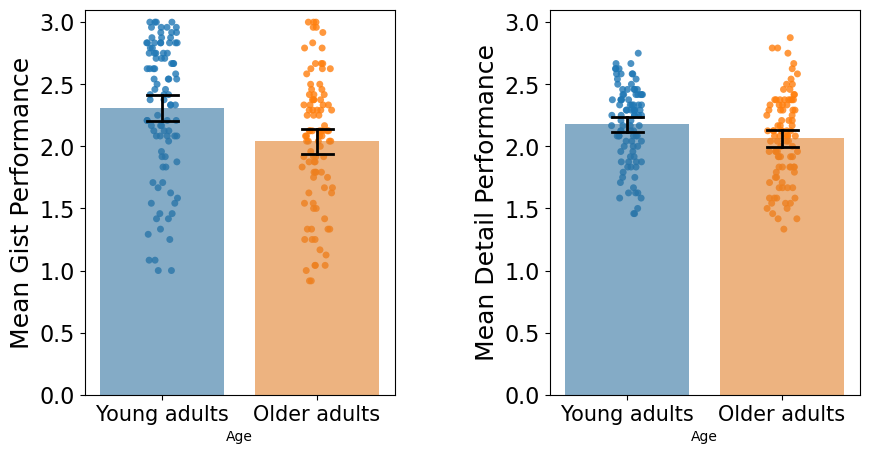

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,5),
                         gridspec_kw={
                               'width_ratios': [1, 1],
                               'wspace': 0.5,
                               'hspace': 0.5})

# gist
plt.axes(axes[0])
sns.barplot(y='total_gist',x='age',data=total_gist, alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='total_gist',x='age',data=total_gist,
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylim(0,3.1)
plt.ylabel('Mean Gist Performance', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)

# detail
plt.axes(axes[1])
sns.barplot(y='total_detail',x='age',data=total_detail, alpha=.6,
            dodge=True, errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(y='total_detail',x='age',data=total_detail,
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylim(0,3.1)
plt.ylabel('Mean Detail Performance', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)

plt.show()

# 2. Subjective and objective memory score correlations

## 2.1 Correlation between total gist and total detail performance (collapsed across content conditions of place/person/object) and subjective ratings

In [39]:
specificity_data = memory_data.copy()
specificity_data['total_gist'] = specificity_data['gist_object'] + specificity_data['gist_person'] + specificity_data['gist_place']
specificity_data['total_detail'] = specificity_data['detail_object'] + specificity_data['detail_person'] + specificity_data['detail_place']

In [40]:
older_specificity_data, younger_specificity_data = [x for _, x in specificity_data.groupby(specificity_data['age'] == 0)]

In [41]:
older_specificity_data_gist_viv = ratings_correlations(older_specificity_data, ['total_gist'], "vividness")
older_specificity_data_gist_conf = ratings_correlations(older_specificity_data, ['total_gist'], "confidence")
older_specificity_data_detail_viv = ratings_correlations(older_specificity_data, ['total_detail'], "vividness")
older_specificity_data_detail_conf = ratings_correlations(older_specificity_data, ['total_detail'], "confidence")
younger_specificity_data_gist_viv = ratings_correlations(younger_specificity_data, ['total_gist'], "vividness")
younger_specificity_data_gist_conf = ratings_correlations(younger_specificity_data, ['total_gist'], "confidence")
younger_specificity_data_detail_viv = ratings_correlations(younger_specificity_data, ['total_detail'], "vividness")
younger_specificity_data_detail_conf = ratings_correlations(younger_specificity_data, ['total_detail'], "confidence")
# fisher z transform before stats
older_specificity_data_gist_viv["z_vividness"] = np.arctanh(older_specificity_data_gist_viv.total_gist.astype('float'))
older_specificity_data_gist_conf["z_confidence"] = np.arctanh(older_specificity_data_gist_conf.total_gist.astype('float'))
older_specificity_data_detail_viv["z_vividness"] = np.arctanh(older_specificity_data_detail_viv.total_detail.astype('float'))
older_specificity_data_detail_conf["z_confidence"] = np.arctanh(older_specificity_data_detail_conf.total_detail.astype('float'))
# fisher z transform before stats
younger_specificity_data_gist_viv["z_vividness"] = np.arctanh(younger_specificity_data_gist_viv.total_gist.astype('float'))
younger_specificity_data_gist_conf["z_confidence"] = np.arctanh(younger_specificity_data_gist_conf.total_gist.astype('float'))
younger_specificity_data_detail_viv["z_vividness"] = np.arctanh(younger_specificity_data_detail_viv.total_detail.astype('float'))
younger_specificity_data_detail_conf["z_confidence"] = np.arctanh(younger_specificity_data_detail_conf.total_detail.astype('float'))

In [42]:
pg.ttest(younger_specificity_data_detail_viv["z_vividness"], older_specificity_data_detail_viv["z_vividness"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.174935,187.482012,two-sided,0.241511,"[-0.03, 0.12]",0.169261,0.298,0.215592


In [43]:
# sanity check to verify that excluding outliers does not change the result
outlier_older = older_specificity_data_detail_viv.loc[~pg.madmedianrule(older_specificity_data_detail_viv['z_vividness'])]
outlier_younger = younger_specificity_data_detail_viv.loc[~pg.madmedianrule(younger_specificity_data_detail_viv['z_vividness'])]
pg.ttest(outlier_younger["z_vividness"], outlier_older["z_vividness"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.809717,180,two-sided,0.072008,"[-0.01, 0.12]",0.26829,0.733,0.436563


In [44]:
pg.ttest(younger_specificity_data_gist_viv["z_vividness"], older_specificity_data_gist_viv["z_vividness"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.081408,188.662819,two-sided,0.280896,"[-0.17, 0.05]",0.155586,0.27,0.189369


In [45]:
# sanity check to verify that excluding outliers does not change the result
outlier_older = older_specificity_data_gist_viv.loc[~pg.madmedianrule(older_specificity_data_gist_viv['z_vividness'])]
outlier_younger = younger_specificity_data_gist_viv.loc[~pg.madmedianrule(younger_specificity_data_gist_viv['z_vividness'])]
pg.ttest(outlier_younger["z_vividness"], outlier_older["z_vividness"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.753592,183.076186,two-sided,0.452062,"[-0.14, 0.06]",0.109335,0.206,0.116076


In [46]:
pg.ttest(younger_specificity_data_gist_conf["z_confidence"], older_specificity_data_gist_conf["z_confidence"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.263128,186.424178,two-sided,0.792743,"[-0.09, 0.11]",0.037848,0.162,0.057875


In [47]:
# sanity check to verify that excluding outliers does not change the result
outlier_older = older_specificity_data_gist_conf.loc[~pg.madmedianrule(older_specificity_data_gist_conf['z_confidence'])]
outlier_younger = younger_specificity_data_gist_conf.loc[~pg.madmedianrule(younger_specificity_data_gist_conf['z_confidence'])]
pg.ttest(outlier_younger["z_confidence"], outlier_older["z_confidence"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.242267,180.164103,two-sided,0.808849,"[-0.08, 0.11]",0.035122,0.162,0.056633


In [48]:
pg.ttest(younger_specificity_data_detail_conf["z_confidence"], older_specificity_data_detail_conf["z_confidence"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.878009,188.813525,two-sided,0.061922,"[-0.0, 0.14]",0.270505,0.806,0.464027


In [49]:
# sanity check to verify that excluding outliers does not change the result
outlier_older = older_specificity_data_detail_conf.loc[~pg.madmedianrule(older_specificity_data_detail_conf['z_confidence'])]
outlier_younger = younger_specificity_data_detail_conf.loc[~pg.madmedianrule(younger_specificity_data_detail_conf['z_confidence'])]
pg.ttest(outlier_younger["z_confidence"], outlier_older["z_confidence"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.116693,175.344104,two-sided,0.002138,"[0.04, 0.16]",0.464248,13.684,0.874045


# REVIEW THIS

**Based on the results above, the correlation between memory performance on both gist and detail memory tasks and both subjective scores does not differ between younger and older adults.**

## 2.2 Setting detail performance to be conditional upon gist performance
**For all subsequent analyses, the performance on detail memory will be set to 0 if participant did not respond correctly to the corresponding gist question**

In [50]:
memory_measures = ["gist_object","gist_person","gist_place","detail_object","detail_person","detail_place"]
# copy for later gist-detail correlations
memory_data_orig = memory_data.copy()

# detail = 0 where gist = 0
memory_data.loc[memory_data['gist_object'] == 0, 'detail_object'] = 0
memory_data.loc[memory_data['gist_person'] == 0, 'detail_person'] = 0
memory_data.loc[memory_data['gist_place'] == 0, 'detail_place'] = 0

# finally, create summary measure
memory_data["total"] = memory_data[memory_measures].sum(axis=1)
# saving data in the format required for an exploratory analysis conducted in R
memory_data.to_csv('.\data\exploratory_analysis.csv') 
memory_data.head()

,participant,event,vividness,confidence,age,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place,total_gist,total_detail,total
0,100,17,1.703704,2.300926,0,0,0,0,0,0,1,1,2,1
1,100,11,5.805556,5.805556,0,0,1,1,1,1,1,3,2,5
2,100,18,5.888889,5.888889,0,1,1,0,1,1,1,3,2,5
3,100,4,2.462963,3.648148,0,1,0,1,1,1,1,3,2,5
4,100,10,5.370371,4.462963,0,1,0,1,1,1,1,3,2,5


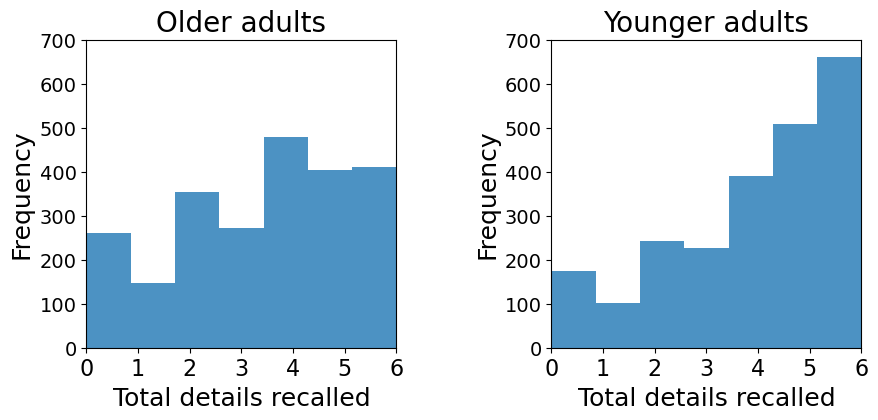

In [51]:
older_part_df, younger_part_df = [x for _, x in memory_data.groupby(memory_data['age'] == 0)]

fig, axes = plt.subplots(1, 2, figsize=(10,4),
                         gridspec_kw={
                               'width_ratios': [3, 3],
                               'wspace': 0.5,
                               'hspace': 0.5})

# plot distribution of total memory scores per event (0-6)
#older adults
plt.axes(axes[0])
older_part_df.hist(ax=axes[0],column='total', bins=7,
                 xlabelsize=16, ylabelsize=14, figsize=(4.5,3),
                 alpha=.8)
plt.xlabel('Total details recalled', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.ylim(0,700)
plt.xlim(0,6)
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.title('Older adults', fontsize=20)
plt.grid(False)

#younger adults
plt.axes(axes[1])
younger_part_df.hist(ax=axes[1],column='total', bins=7,
                 xlabelsize=16, ylabelsize=14, figsize=(4.5,3),
                 alpha=.8)
plt.xlabel('Total details recalled', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.ylim(0,700)
plt.xlim(0,6)
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.title('Younger adults', fontsize=20)
plt.grid(False)



plt.show()

In [52]:
# check detail memory again when conditional upon correct gist:

# young adults
print('*** Older adults ***\n')
print('Conditional detail object:',older_part_df[older_part_df.gist_object == 1].groupby('participant').mean().mean()['detail_object'])
print('Conditional detail person:',older_part_df[older_part_df.gist_person == 1].groupby('participant').mean().mean()['detail_person'])
print('Conditional detail place:',older_part_df[older_part_df.gist_place == 1].groupby('participant').mean().mean()['detail_place'])

# older adults
print('\n\n*** Young adults ***\n')
print('Conditional detail object:',younger_part_df[younger_part_df.gist_object == 1].groupby('participant').mean().mean()['detail_object'])
print('Conditional detail person:',younger_part_df[younger_part_df.gist_person == 1].groupby('participant').mean().mean()['detail_person'])
print('Conditional detail place:',younger_part_df[younger_part_df.gist_place == 1].groupby('participant').mean().mean()['detail_place'])

*** Older adults ***

Conditional detail object: 0.7147059395540896
Conditional detail person: 0.6941204729029989
Conditional detail place: 0.6632095875714675


*** Young adults ***

Conditional detail object: 0.739144562375261
Conditional detail person: 0.7481774939472391
Conditional detail place: 0.7293227452869457


## 2.3 Correlation between total number of attributes remembered (collapsed across specificity conditions of gist/detail and content conditions of place/person/object) and subjective ratings

### 2.3.1 Vividness

#### Older adults

In [53]:
# run correlation, fetching r per subject and feature:
cor_params_vivid_older = ratings_correlations(older_part_df, ['total'], "vividness")

# fisher z transform before stats
cor_params_vivid_older["z_vividness"] = np.arctanh(cor_params_vivid_older.total.astype('float'))

# one-sample t-test
pg.ttest(cor_params_vivid_older.z_vividness, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.741766,96,two-sided,2.114264e-24,"[0.44, 0.59]",1.395265,1.92e+21,1.0


In [54]:
# sanity check to verify that excluding outliers do not change the result
outlier_older = cor_params_vivid_older.loc[~pg.madmedianrule(cor_params_vivid_older['z_vividness'])]
pg.ttest(outlier_older.z_vividness, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.921024,95,two-sided,1.148840e-24,"[0.43, 0.57]",1.420809,3.49e+21,1.0


In [55]:
# group average older
pd.DataFrame(cor_params_vivid_older.agg(Mean=('z_vividness', 'mean'),
                             SE=('z_vividness', 'sem')))

,z_vividness
Mean,0.513768
SE,0.037387


#### Young adults

In [56]:
# run correlation, fetching r per subject and feature:
cor_params_vivid_young = ratings_correlations(younger_part_df, ['total'], "vividness")

# fisher z transform before stats
cor_params_vivid_young["z_vividness"] = np.arctanh(cor_params_vivid_young.total.astype('float'))

# one-sample t-test
pg.ttest(cor_params_vivid_young.z_vividness, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,12.524649,95,two-sided,7.912877e-22,"[0.39, 0.54]",1.278292,5.791e+18,1.0


In [57]:
# sanity check to verify that excluding outliers do not change the result
outlier_young = cor_params_vivid_young.loc[~pg.madmedianrule(cor_params_vivid_young['z_vividness'])]
pg.ttest(outlier_young.z_vividness, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.841113,93,two-sided,2.597021e-24,"[0.41, 0.55]",1.427602,1.568e+21,1.0


In [58]:
# group average young
pd.DataFrame(cor_params_vivid_young.agg(Mean=('z_vividness', 'mean'),
                             SE=('z_vividness', 'sem')))

,z_vividness
Mean,0.463489
SE,0.037006


**Is the relationship between vividness and total memory attributes remembered different between the two age groups?**

In [59]:
# two-sample t-test
pg.ttest(cor_params_vivid_young.z_vividness, cor_params_vivid_older.z_vividness)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.95579,190.995201,two-sided,0.340386,"[-0.15, 0.05]",0.137589,0.24,0.158277


In [60]:
# sanity check to verify that excluding outliers do not change the result
pg.ttest(outlier_young.z_vividness, outlier_older.z_vividness)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.383782,187.903156,two-sided,0.701574,"[-0.12, 0.08]",0.055662,0.169,0.066847


### 2.3.2 Confidence

#### Older adults

In [61]:
# run correlation, fetching r per subject and feature:
cor_params_conf_older = ratings_correlations(older_part_df, ['total'], "confidence")

# fisher z transform before stats
cor_params_conf_older["z_confidence"] = np.arctanh(cor_params_conf_older.total.astype('float'))

# one-sample t-test
pg.ttest(cor_params_conf_older.z_confidence, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.827968,96,two-sided,1.442571e-26,"[0.48, 0.62]",1.505552,2.559e+23,1.0


In [62]:
# sanity check to verify that excluding outliers do not change the result
outlier_older = cor_params_conf_older.loc[~pg.madmedianrule(cor_params_conf_older['z_confidence'])]
pg.ttest(outlier_older.z_confidence, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.174598,95,two-sided,3.939962e-27,"[0.47, 0.61]",1.548751,9.142e+23,1.0


In [63]:
# group average older
pd.DataFrame(cor_params_conf_older.agg(Mean=('z_confidence', 'mean'),
                             SE=('z_confidence', 'sem')))

,z_confidence
Mean,0.551014
SE,0.037160


#### Young adults

In [64]:
# run correlation, fetching r per subject and feature:
cor_params_conf_young = ratings_correlations(younger_part_df, ['total'], "confidence")

# fisher z transform before stats
cor_params_conf_young["z_confidence"] = np.arctanh(cor_params_conf_young.total.astype('float'))

# one-sample t-test
pg.ttest(cor_params_conf_young.z_confidence, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.739449,95,two-sided,4.342196e-30,"[0.48, 0.61]",1.708463,7.358e+26,1.0


In [65]:
# sanity check to verify that excluding outliers do not change the result
outlier_young = cor_params_conf_young.loc[~pg.madmedianrule(cor_params_conf_young['z_confidence'])]
pg.ttest(outlier_young.z_confidence, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,21.206145,90,two-sided,9.043170e-37,"[0.54, 0.65]",2.223008,2.735e+33,1.0


In [66]:
# group average young
pd.DataFrame(cor_params_conf_young.agg(Mean=('z_confidence', 'mean'),
                             SE=('z_confidence', 'sem')))

,z_confidence
Mean,0.549063
SE,0.032801


**Is the relationship between confidence and total memory attributes different between the two age groups?**

In [67]:
# two-sample t-test
pg.ttest(cor_params_conf_young.z_confidence, cor_params_conf_older.z_confidence)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.039362,188.336456,two-sided,0.968644,"[-0.1, 0.1]",0.005663,0.157,0.050175


In [68]:
# sanity check to verify that excluding outliers do not change the result
pg.ttest(outlier_young.z_confidence, outlier_older.z_confidence)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.193683,177.339304,two-sided,0.234196,"[-0.04, 0.14]",0.173428,0.308,0.218325


## 2.4 Correlation between the correlation coefficients of vividness and total number of remembered attributes, and confidence and total number of remembered attributes

#### Older adults

In [69]:
cor_params_conf_viv_older = pd.DataFrame(index=older_part_df['participant'].unique(),
                        columns=['vivid_conf_corr'])
for p in older_part_df['participant'].unique():
    sub_data = older_part_df[older_part_df['participant'] == p]

    # correlate with vividness
    sub_cors = sub_data[['vividness','confidence']].corr(method="spearman").loc['vividness','confidence'].astype('float')
    cor_params_conf_viv_older.loc[p,['vivid_conf_corr']] = sub_cors
cor_params_conf_viv_older.reset_index()

# fisher z transform before stats
cor_params_conf_viv_older["vivid_conf_corr_z"] = np.arctanh(cor_params_conf_viv_older.vivid_conf_corr.astype('float'))

# one-sample t-test
pg.ttest(cor_params_conf_viv_older.vivid_conf_corr_z, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,24.20963,96,two-sided,1.164160e-42,"[1.25, 1.47]",2.458115,1.776e+39,1.0


In [70]:
# sanity check to verify that excluding outliers do not change the result
outlier_older = cor_params_conf_viv_older.loc[~pg.madmedianrule(cor_params_conf_viv_older['vivid_conf_corr_z'])]
pg.ttest(outlier_older.vivid_conf_corr_z, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,25.959819,94,two-sided,1.173038e-44,"[1.28, 1.49]",2.663421,1.645e+41,1.0


#### Young adults

In [71]:
cor_params_conf_viv_younger = pd.DataFrame(index=younger_part_df['participant'].unique(),
                        columns=['vivid_conf_corr'])
for p in younger_part_df['participant'].unique():
    sub_data = younger_part_df[younger_part_df['participant'] == p]

    # correlate with vividness
    sub_cors = sub_data[['vividness','confidence']].corr(method="spearman").loc['vividness','confidence'].astype('float')
    cor_params_conf_viv_younger.loc[p,['vivid_conf_corr']] = sub_cors
cor_params_conf_viv_younger.reset_index()

# fisher z transform before stats
cor_params_conf_viv_younger["vivid_conf_corr_z"] = np.arctanh(cor_params_conf_viv_younger.vivid_conf_corr.astype('float'))

# one-sample t-test
pg.ttest(cor_params_conf_viv_younger.vivid_conf_corr_z, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.873967,95,two-sided,2.453278e-30,"[0.99, 1.25]",1.722192,1.29e+27,1.0


In [72]:
# sanity check to verify that excluding outliers do not change the result
outlier_young = cor_params_conf_viv_younger.loc[~pg.madmedianrule(cor_params_conf_viv_younger['vivid_conf_corr_z'])]
pg.ttest(outlier_older.vivid_conf_corr_z, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,25.959819,94,two-sided,1.173038e-44,"[1.28, 1.49]",2.663421,1.645e+41,1.0


**Is the correlation between confidence and vividness different between the two age groups?**

In [73]:
# two-sample t-test
pg.ttest(cor_params_conf_viv_younger.vivid_conf_corr_z, cor_params_conf_viv_older.vivid_conf_corr_z)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.714491,185.413129,two-sided,0.007264,"[-0.41, -0.06]",0.391125,4.688,0.771307


In [74]:
# sanity check to verify that excluding outliers do not change the result
pg.ttest(outlier_young.vivid_conf_corr_z, outlier_older.vivid_conf_corr_z)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.537843,183.733947,two-sided,0.000511,"[-0.4, -0.11]",0.518024,47.732,0.93981


## 3. Content x Specificity x Age

### 3.1 The effect of content x specificity x age on vividness ratings

In [75]:
cor_params_gist = ratings_correlations(memory_data, ["gist_object","gist_person","gist_place"], "vividness").melt(id_vars=["index", "age"], var_name="content", value_name='gist')
cor_params_gist['content'].replace({"gist_object":"object", "gist_person":"person", "gist_place":"place"}, inplace=True)

In [76]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object = ratings_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"], "vividness")
cor_detail_person = ratings_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"], "vividness")
cor_detail_place = ratings_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"], "vividness")

# merge detail to single df:
cor_params_detail = cor_detail_object.merge(cor_detail_person)
cor_params_detail = cor_params_detail.merge(cor_detail_place).melt(id_vars=["index", "age"], var_name="content", value_name="detail")
cor_params_detail['content'].replace({"detail_object":"object", "detail_person":"person", "detail_place":"place"}, inplace=True)

In [77]:
# merge gist and detail to single df:
cor_params = cor_params_detail.merge(cor_params_gist, how="outer")
cor_params = cor_params.melt(id_vars=["index","age","content"], var_name="specificity", value_name="r")
cor_params.head()

,index,age,content,specificity,r
0,100,0,object,detail,-0.145526
1,101,0,object,detail,0.382971
2,102,0,object,detail,0.19605
3,103,0,object,detail,-0.24216
4,104,0,object,detail,0.328564


In [78]:
# fisher z transform before stats
cor_params["z_vividness"] = np.arctanh(cor_params.r.astype('float'))
cor_params.head()

,index,age,content,specificity,r,z_vividness
0,100,0,object,detail,-0.145526,-0.146567
1,101,0,object,detail,0.382971,0.403536
2,102,0,object,detail,0.19605,0.198622
3,103,0,object,detail,-0.24216,-0.247067
4,104,0,object,detail,0.328564,0.341218


**Group averages by age, content and specificity**

In [79]:
# group averages by age, content and specificity:
pd.DataFrame(cor_params.groupby(['age','content','specificity']).agg(Mean=('z_vividness', 'mean'),
                                                               SE=('z_vividness', 'sem')))

Mean        SE
age content specificity                    
0   object  detail       0.066518  0.028815
            gist         0.308331  0.029675
    person  detail       0.026304  0.036819
            gist         0.333779  0.030919
    place   detail       0.079061  0.027775
            gist         0.326042  0.029290
1   object  detail       0.060529  0.028366
            gist         0.346456  0.028329
    person  detail       0.011371  0.035886
            gist         0.358071  0.026781
    place   detail       0.005193  0.035711
            gist         0.372831  0.032616

In [80]:
older_cor_params, younger_cor_params = [x for _, x in cor_params.groupby(cor_params['age'] == 0)]

#### Older adults

In [81]:
# one-sample t-tests:
tests = content_specificity_t_test(older_cor_params, "z_vividness")
tests

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,content,specificity,p-bonf
T-test,2.1338,96,two-sided,0.0354,"[0.0, 0.12]",0.2167,0.978,0.5606,object,detail,0.2124
T-test,12.2297,96,two-sided,0.0000,"[0.29, 0.4]",1.2417,1.726e+18,1.0000,object,gist,0.0000
T-test,0.3169,96,two-sided,0.7520,"[-0.06, 0.08]",0.0322,0.118,0.0613,person,detail,1.0000
T-test,13.3705,96,two-sided,0.0000,"[0.3, 0.41]",1.3576,3.502e+20,1.0000,person,gist,0.0000
T-test,0.1454,96,two-sided,0.8847,"[-0.07, 0.08]",0.0148,0.114,0.0524,place,detail,1.0000
T-test,11.4310,96,two-sided,0.0000,"[0.31, 0.44]",1.1606,3.926e+16,1.0000,place,gist,0.0000


#### Younger adults

In [82]:
tests = content_specificity_t_test(younger_cor_params, "z_vividness")
tests

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,content,specificity,p-bonf
T-test,2.3085,95,two-sided,0.0231,"[0.01, 0.12]",0.2356,1.406,0.6275,object,detail,0.1386
T-test,10.3904,95,two-sided,0.0000,"[0.25, 0.37]",1.0605,2.402e+14,1.0000,object,gist,0.0000
T-test,0.7144,95,two-sided,0.4767,"[-0.05, 0.1]",0.0729,0.145,0.1090,person,detail,1.0000
T-test,10.7952,95,two-sided,0.0000,"[0.27, 0.4]",1.1018,1.66e+15,1.0000,person,gist,0.0000
T-test,2.8465,95,two-sided,0.0054,"[0.02, 0.13]",0.2905,4.965,0.8044,place,detail,0.0324
T-test,11.1316,95,two-sided,0.0000,"[0.27, 0.38]",1.1361,8.236e+15,1.0000,place,gist,0.0000


**Given that younger adults demonstrate a significant correlation between vividness ratings and detail place memory performance and older adults do not, is there a significant difference between the age groups on this measure?**

In [83]:
older_detail_place = older_cor_params.loc[(older_cor_params['specificity'] == 'detail') & (older_cor_params['content'] == 'place')]
young_detail_place = younger_cor_params.loc[(younger_cor_params['specificity'] == 'detail') & (younger_cor_params['content'] == 'place')]

In [84]:
pg.ttest(young_detail_place['z_vividness'], older_detail_place['z_vividness'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.632773,180.521991,two-sided,0.10426,"[-0.02, 0.16]",0.234755,0.541,0.368032


### 3.2 The effect of content x specificity x age on confidence ratings

In [85]:
cor_params_gist_conf = ratings_correlations(memory_data, ["gist_object","gist_person","gist_place"], "confidence").melt(id_vars=["index", "age"], var_name="content", value_name='gist')
cor_params_gist_conf['content'].replace({"gist_object":"object", "gist_person":"person", "gist_place":"place"}, inplace=True)

In [86]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object_conf = ratings_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"], "confidence")
cor_detail_person_conf = ratings_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"], "confidence")
cor_detail_place_conf = ratings_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"], "confidence")

# merge detail to single df:
cor_params_detail_conf = cor_detail_object_conf.merge(cor_detail_person_conf)
cor_params_detail_conf = cor_params_detail_conf.merge(cor_detail_place_conf).melt(id_vars=["index", "age"], var_name="content", value_name="detail")
cor_params_detail_conf['content'].replace({"detail_object":"object", "detail_person":"person", "detail_place":"place"}, inplace=True)

In [87]:
# merge gist and detail to single df:
cor_params_conf = cor_params_detail_conf.merge(cor_params_gist_conf, how="outer")
cor_params_conf = cor_params_conf.melt(id_vars=["index","age","content"], var_name="specificity", value_name="r")
cor_params_conf

,index,age,content,specificity,r
0,100,0,object,detail,-0.205216
1,101,0,object,detail,0.382971
2,102,0,object,detail,0.087133
3,103,0,object,detail,-0.319997
4,104,0,object,detail,0.36315
...,...,...,...,...,...
1153,96,0,place,gist,0.258237
1154,97,0,place,gist,0.201981
1155,98,0,place,gist,0.015061
1156,99,0,place,gist,0.413794


In [88]:
# fisher z transform before stats
cor_params_conf["z_confidence"] = np.arctanh(cor_params_conf.r.astype('float'))
cor_params_conf.head()

,index,age,content,specificity,r,z_confidence
0,100,0,object,detail,-0.205216,-0.208172
1,101,0,object,detail,0.382971,0.403536
2,102,0,object,detail,0.087133,0.087355
3,103,0,object,detail,-0.319997,-0.331644
4,104,0,object,detail,0.36315,0.380510


**Group averages by age, content and specificity**

In [89]:
# group averages by age, content and specificity:
pd.DataFrame(cor_params_conf.groupby(['age','content','specificity']).agg(Mean=('z_confidence', 'mean'),
                                                               SE=('z_confidence', 'sem')))

Mean        SE
age content specificity                    
0   object  detail       0.097613  0.031478
            gist         0.359298  0.025970
    person  detail       0.030276  0.034957
            gist         0.404465  0.030727
    place   detail       0.104953  0.026201
            gist         0.337514  0.028994
1   object  detail       0.036013  0.030769
            gist         0.356651  0.026677
    person  detail       0.074011  0.033280
            gist         0.371993  0.027578
    place   detail       0.053884  0.037239
            gist         0.407779  0.032851

In [90]:
older_cor_params, younger_cor_params = [x for _, x in cor_params_conf.groupby(cor_params['age'] == 0)]

#### Older adults

In [91]:
tests = content_specificity_t_test(older_cor_params, "z_confidence")
tests

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,content,specificity,p-bonf
T-test,1.1704,96,two-sided,0.2447,"[-0.03, 0.1]",0.1188,0.218,0.2124,object,detail,1.0000
T-test,13.3692,96,two-sided,0.0000,"[0.3, 0.41]",1.3574,3.48e+20,1.0000,object,gist,0.0000
T-test,2.2239,96,two-sided,0.0285,"[0.01, 0.14]",0.2258,1.174,0.5955,person,detail,0.1710
T-test,13.4889,96,two-sided,0.0000,"[0.32, 0.43]",1.3696,6.034e+20,1.0000,person,gist,0.0000
T-test,1.4470,96,two-sided,0.1512,"[-0.02, 0.13]",0.1469,0.308,0.2993,place,detail,0.9072
T-test,12.4131,96,two-sided,0.0000,"[0.34, 0.47]",1.2604,4.087e+18,1.0000,place,gist,0.0000


#### Young adults

In [92]:
tests = content_specificity_t_test(younger_cor_params, "z_confidence")
tests

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,content,specificity,p-bonf
T-test,3.1010,95,two-sided,0.0025,"[0.04, 0.16]",0.3165,9.746,0.8664,object,detail,0.0150
T-test,13.8349,95,two-sided,0.0000,"[0.31, 0.41]",1.4120,2.365e+21,1.0000,object,gist,0.0000
T-test,0.8661,95,two-sided,0.3886,"[-0.04, 0.1]",0.0884,0.162,0.1375,person,detail,1.0000
T-test,13.1630,95,two-sided,0.0000,"[0.34, 0.47]",1.3434,1.107e+20,1.0000,person,gist,0.0000
T-test,4.0057,95,two-sided,0.0001,"[0.05, 0.16]",0.4088,154.365,0.9775,place,detail,0.0006
T-test,11.6408,95,two-sided,0.0000,"[0.28, 0.4]",1.1881,9.191e+16,1.0000,place,gist,0.0000


**Merging vividness and confidence correlation datasets, and then splitting them by age for the ease of plotting**

In [93]:
cor_params= cor_params.rename(columns={'index': 'participant', 'r': 'r_vividness'})
cor_params_conf = cor_params_conf.rename(columns={'index': 'participant', 'r': 'r_confidence'})
cor_params_merged = cor_params_conf.merge(cor_params, on=['participant', 'age', 'content', 'specificity'])
older_part_cor, younger_part_cor = [x for _, x in cor_params_merged.groupby(cor_params_merged['age'] == 0)]

In [94]:
# rearranging data for plotting
cor_params_viv_younger = younger_part_cor.copy()
cor_params_viv_younger = cor_params_viv_younger.pivot(index='participant', columns=['specificity','content'], values='r_vividness')
cor_params_viv_younger.columns = cor_params_viv_younger.columns.map('_'.join)
cor_params_viv_younger = cor_params_viv_younger[memory_measures].melt()

cor_params_viv_older = older_part_cor.copy()
cor_params_viv_older = cor_params_viv_older.pivot(index='participant', columns=['specificity','content'], values='r_vividness')
cor_params_viv_older.columns = cor_params_viv_older.columns.map('_'.join)
cor_params_viv_older = cor_params_viv_older[memory_measures].melt()

cor_params_conf_younger = younger_part_cor.copy()
cor_params_conf_younger = cor_params_conf_younger.pivot(index='participant', columns=['specificity','content'], values='r_confidence')
cor_params_conf_younger.columns = cor_params_conf_younger.columns.map('_'.join)
cor_params_conf_younger = cor_params_conf_younger[memory_measures].melt()
cor_params_conf_younger

cor_params_conf_older = older_part_cor.copy()
cor_params_conf_older = cor_params_conf_older.pivot(index='participant', columns=['specificity','content'], values='r_confidence')
cor_params_conf_older.columns = cor_params_conf_older.columns.map('_'.join)
cor_params_conf_older = cor_params_conf_older[memory_measures].melt()
cor_params_conf_older

,variable,value
0,gist_object,0.193817
1,gist_object,0.155485
2,gist_object,0.416519
3,gist_object,0.509852
4,gist_object,0.235674
...,...,...
577,detail_place,-0.251976
578,detail_place,0.0
579,detail_place,0.028915
580,detail_place,0.189098


In [95]:
pal = sns.color_palette("colorblind")
colors = pal.as_hex()[:3]
colors.reverse()

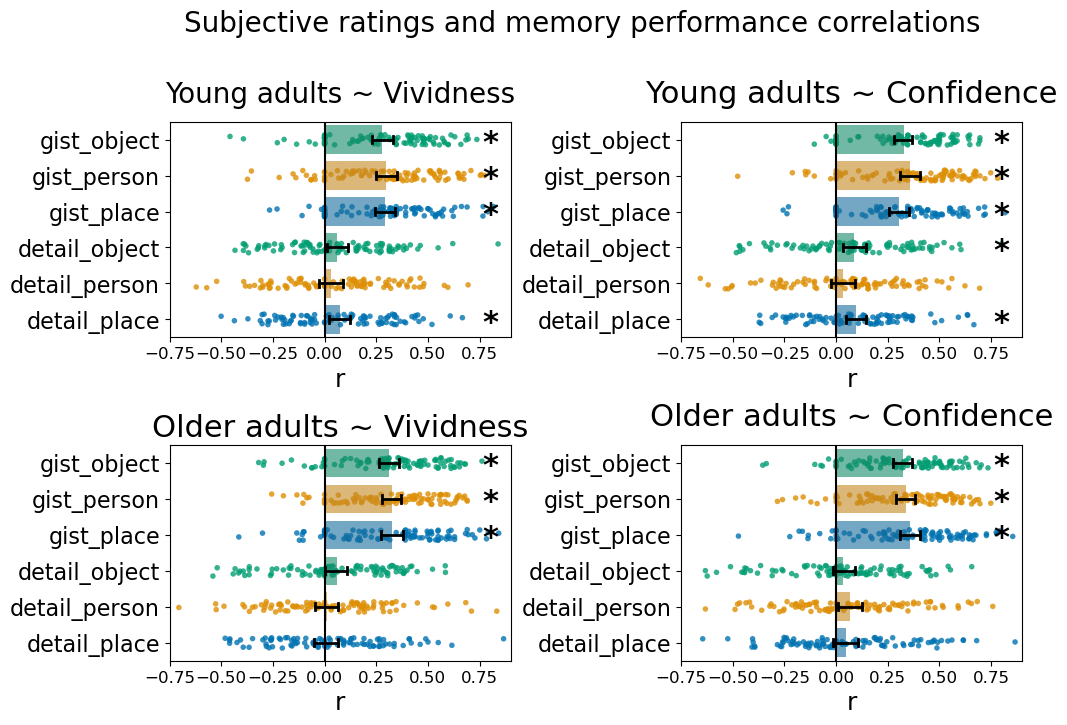

In [96]:
# plotting younger adults descriptive data:
fig, axes = plt.subplots(2,2, figsize=(11,7),
                         gridspec_kw={
                               'width_ratios': [1, 1],
                               'wspace': 0.5,
                               'hspace': 0.5})

fig.suptitle('Subjective ratings and memory performance correlations', fontsize=20, y =1.04)

plt.axes(axes[0,0])
sns.barplot(data=cor_params_viv_younger, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_viv_younger, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 5.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Young adults ~ Vividness', fontsize=20, y=1.05)


plt.axes(axes[1,0])

sns.barplot(data=cor_params_viv_older, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_viv_older, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Older adults ~ Vividness', fontsize=22, y=1.0)


plt.axes(axes[0,1])
sns.barplot(data=cor_params_conf_younger, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_conf_younger, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 3.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 5.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Young adults ~ Confidence', fontsize=22, y=1.05)


plt.axes(axes[1,1])

sns.barplot(data=cor_params_conf_older, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_conf_older, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Older adults ~ Confidence', fontsize=22, y=1.05)


# save
plt.savefig(".\\plots\\vivid_conf_trialwise_correlations.png", bbox_inches = 'tight')
plt.show()

## 4. Mixed-design 3x2x2 ANOVA

**Performed in R due to limited Python packages supporting performing mixed design 3-way ANOVAs**

In [97]:
cor_params_merged.to_csv('.\data\correlation_coefficients_R.csv')

## 5. Predictive Model


Following Cooper Ritchey (2022), we are using linear regression, with cross-validation -- data from across all subjects (so 24 events * Nsubs).
Starting with all the features, we will iterate and at each iteration remove the predictor with the lowest R-squared value until we obtain the one which accounts for the most variance in the data.

**The model returned is that with the highest *out-of-sample* R-squared value**

### 5.1 Vividness

#### Older adults

In [98]:
older_part_df, younger_part_df = [x for _, x in memory_data.groupby(memory_data['age'] == 0)]

In [99]:
y = older_part_df['vividness']
X = older_part_df[memory_measures]

In [100]:
model_weights_older_vividness = regressions(X, y, '')

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
R-squared = 0.24795 ( +/- 0.03801 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person']
R-squared = 0.24717 ( +/- 0.03818 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object']
R-squared = 0.24587 ( +/- 0.03905 )

Features = ['gist_object', 'gist_person', 'gist_place']
R-squared = 0.24147 ( +/- 0.03872 )

Features = ['gist_person', 'gist_place']
R-squared = 0.21695 ( +/- 0.03528 )

Features = ['gist_place']
R-squared = 0.14589 ( +/- 0.03113 )


 FEATURE ACCOUNTING FOR MOST VARIANCE: 

['gist_place']

*BEST MODEL*:

R-squared = 0.248
Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place'] 



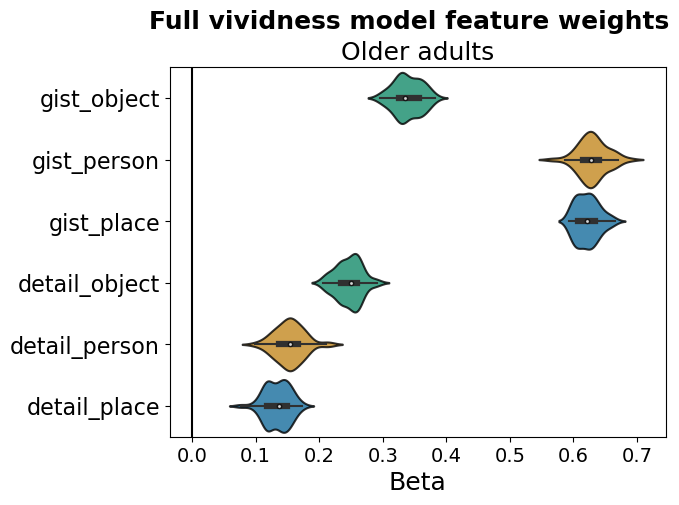

In [101]:
g = sns.violinplot(data=model_weights_older_vividness.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors), width=0.95)

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.suptitle('Full vividness model feature weights', fontsize=18, y=1.0, fontweight="bold")
plt.title('Older adults', fontsize=18, y=0.999)
plt.savefig("plots/vividness_linear_older.png", bbox_inches = 'tight')

#### Young adults

In [102]:
y = younger_part_df['vividness']
X = younger_part_df[memory_measures]

In [103]:
model_weights_young_vividness = regressions(X, y, '')

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
R-squared = 0.24296 ( +/- 0.04071 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_place']
R-squared = 0.24331 ( +/- 0.04029 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_place']
R-squared = 0.24368 ( +/- 0.03915 )

Features = ['gist_object', 'gist_person', 'gist_place']
R-squared = 0.24226 ( +/- 0.03933 )

Features = ['gist_object', 'gist_place']
R-squared = 0.20912 ( +/- 0.03819 )

Features = ['gist_object']
R-squared = 0.14824 ( +/- 0.03283 )


 FEATURE ACCOUNTING FOR MOST VARIANCE: 

['gist_object']

*BEST MODEL*:

R-squared = 0.2437
Features = ['gist_object', 'gist_person', 'gist_place', 'detail_place'] 



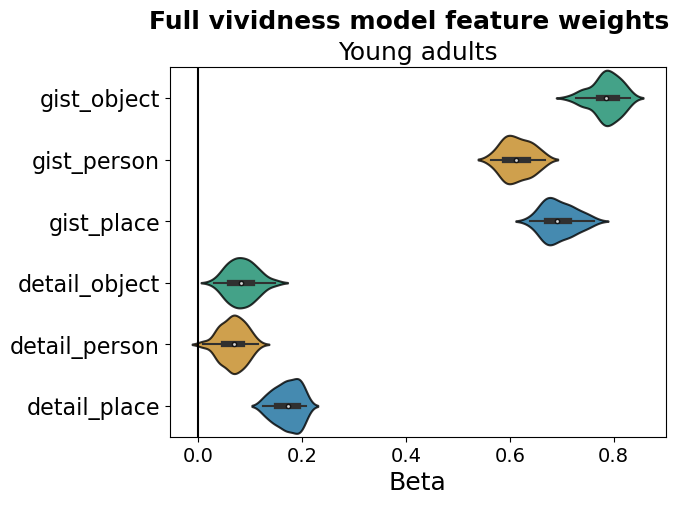

In [104]:
g = sns.violinplot(data=model_weights_young_vividness.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors), width=0.95)

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.suptitle('Full vividness model feature weights', fontsize=18, y=1.0, fontweight="bold")
plt.title('Young adults', fontsize=18, y=0.999)
plt.savefig("plots/vividness_linear_young.png", bbox_inches = 'tight')

### 5.2 Confidence

#### Older adults

In [105]:
y = older_part_df['confidence']
X = older_part_df[memory_measures]

In [106]:
model_weights_older_confidence = regressions(X, y, '')

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
R-squared = 0.3092 ( +/- 0.03834 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person']
R-squared = 0.30904 ( +/- 0.03793 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_person']
R-squared = 0.30724 ( +/- 0.03834 )

Features = ['gist_object', 'gist_person', 'gist_place']
R-squared = 0.30535 ( +/- 0.03945 )

Features = ['gist_person', 'gist_place']
R-squared = 0.27206 ( +/- 0.03907 )

Features = ['gist_place']
R-squared = 0.18389 ( +/- 0.03634 )


 FEATURE ACCOUNTING FOR MOST VARIANCE: 

['gist_place']

*BEST MODEL*:

R-squared = 0.3092
Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place'] 



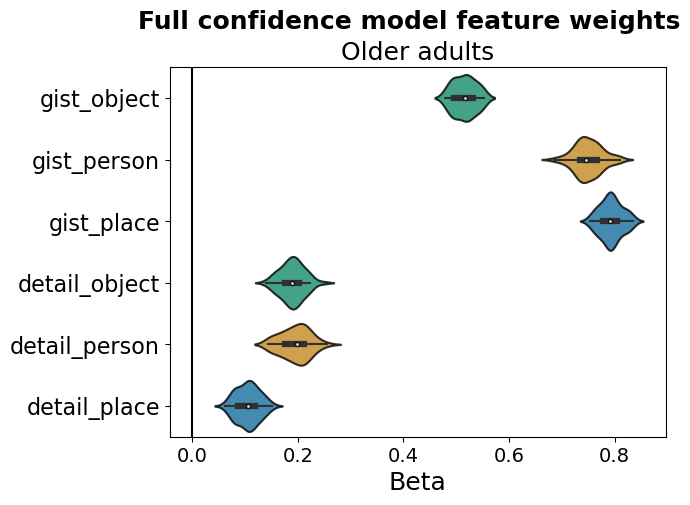

In [107]:
g = sns.violinplot(data=model_weights_older_confidence.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors), width=0.95)

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.suptitle('Full confidence model feature weights', fontsize=18, y=1.0, fontweight="bold")
plt.title('Older adults', fontsize=18, y=0.999)
plt.savefig("plots/confidence_linear_older.png", bbox_inches = 'tight')

#### Younger adults

In [108]:
y = younger_part_df['confidence']
X = younger_part_df[memory_measures]

In [109]:
model_weights_young_confidence = regressions(X, y, '')

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
R-squared = 0.43348 ( +/- 0.04443 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_place']
R-squared = 0.43369 ( +/- 0.04466 )

Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object']
R-squared = 0.43176 ( +/- 0.04479 )

Features = ['gist_object', 'gist_person', 'gist_place']
R-squared = 0.42723 ( +/- 0.0435 )

Features = ['gist_object', 'gist_person']
R-squared = 0.37333 ( +/- 0.04534 )

Features = ['gist_object']
R-squared = 0.25377 ( +/- 0.04045 )


 FEATURE ACCOUNTING FOR MOST VARIANCE: 

['gist_object']

*BEST MODEL*:

R-squared = 0.4337
Features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_place'] 



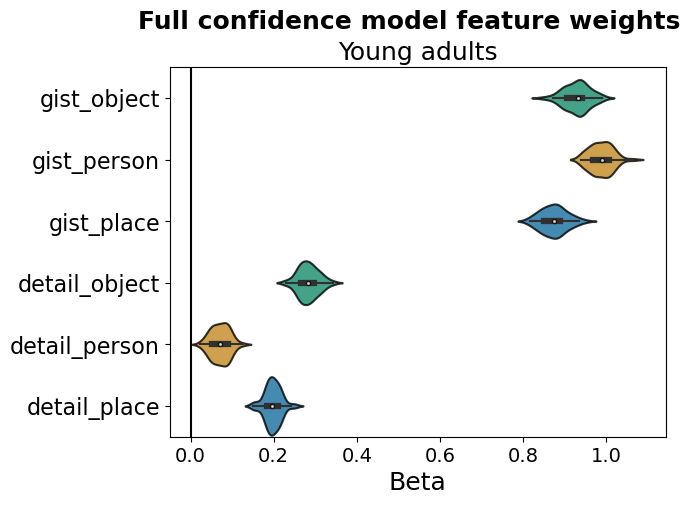

In [110]:
g = sns.violinplot(data=model_weights_young_confidence.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors), width=0.95)

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.suptitle('Full confidence model feature weights', fontsize=18, y=1.0, fontweight="bold")
plt.title('Young adults', fontsize=18, y=0.999)
plt.savefig("plots/confidence_linear_young.png", bbox_inches = 'tight')

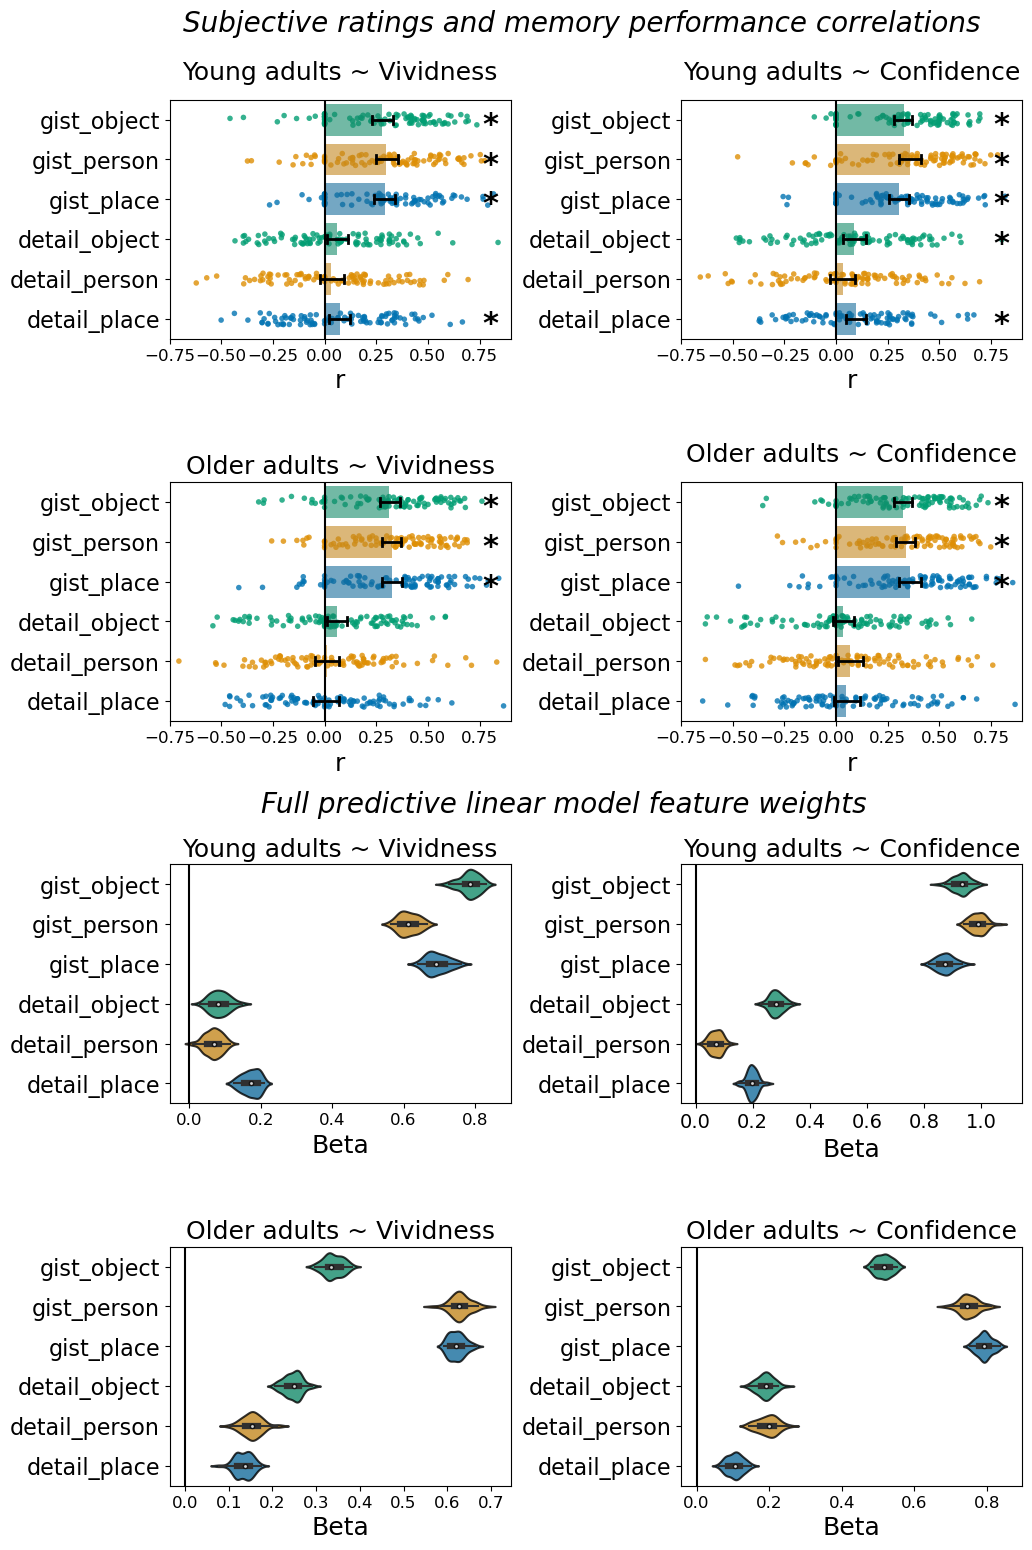

In [111]:
# plotting younger adults descriptive data:
fig, axes = plt.subplots(4,2, figsize=(11,18),
                         gridspec_kw={
                               'width_ratios': [1, 1],
                               'wspace': 0.5,
                               'hspace': 0.6})

fig.suptitle('Subjective ratings and memory performance correlations', style='italic', fontsize=20, y =0.93)

plt.axes(axes[0,0])
sns.barplot(data=cor_params_viv_younger, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_viv_younger, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 5.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Young adults ~ Vividness', fontsize=18, y=1.05)


plt.axes(axes[1,0])

sns.barplot(data=cor_params_viv_older, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_viv_older, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Older adults ~ Vividness', fontsize=18, y=1.0)

plt.axes(axes[2,0])

plt.text(0.2, -1.8, "Full predictive linear model feature weights", style='italic', fontsize=20)

g = sns.violinplot(data=model_weights_young_vividness.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors))

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Young adults ~ Vividness', fontsize=18, y=0.999)

plt.axes(axes[3,0])

g = sns.violinplot(data=model_weights_older_vividness.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors))

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Older adults ~ Vividness', fontsize=18, y=0.999)



plt.axes(axes[0,1])
sns.barplot(data=cor_params_conf_younger, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_conf_younger, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 3.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 5.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Young adults ~ Confidence', fontsize=18, y=1.05)


plt.axes(axes[1,1])

sns.barplot(data=cor_params_conf_older, y='variable', x='value',
            palette=sns.color_palette(colors + colors),
            alpha=.6, dodge=True,
            errcolor="k", errwidth=2, capsize=.2)
sns.stripplot(data=cor_params_conf_older, y='variable', x='value',
              palette=sns.color_palette(colors + colors),
              dodge=True, size=4, zorder=0, alpha=.8, jitter=.15)

# statistical annotation
plt.text(.8, 0.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 1.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')
plt.text(.8, 2.5, "*", ha='center', va='bottom', color="k",
         fontsize=22, fontweight='bold')

plt.xlabel('r', fontsize=18)
plt.xticks(fontsize=12)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlim([-.75, .9])
plt.title('Older adults ~ Confidence', fontsize=18, y=1.05)

plt.axes(axes[2,1])

g = sns.violinplot(data=model_weights_young_confidence.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors), width=0.95)

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=14)
plt.title('Young adults ~ Confidence', fontsize=18, y=0.999)

plt.axes(axes[3,1])

g = sns.violinplot(data=model_weights_older_confidence.melt(),
                   y='variable', x='value',
                   palette=sns.color_palette(colors + colors))

for violin in g.collections:
    violin.set_alpha(0.8)
    violin.set_edgecolor('k')
plt.xlabel('Beta', fontsize=18)
plt.axvline(0, color='k')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Older adults ~ Confidence', fontsize=18, y=0.999)


# save
plt.savefig(".\\plots\\vivid_conf_trialwise_correlations_and_regression.png", bbox_inches = 'tight')
plt.show()